In [1]:
import os 
import numpy  as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from pyogrio import read_dataframe
import time
import glob 
import plotly.graph_objects as go
import pandas as pd
import networkx as nx
import osmnx as ox
import warnings


# Read Daily Travel Data in Houston-Galveston

In [14]:
pth_root = r"/Users/yuhan/Desktop/Gradient_Boost_code/inputs/travel/daily_01-01"
pth1 = pth_root +"/daily_ct2ct_2019_01_01_0.csv"
travel_daily  = pd.read_csv(pth1)

In [15]:
path = os.getcwd() 
csv_files = glob.glob(os.path.join(pth_root, "*.csv")) 

df_daily = []
# loop over the list of csv files 
for f in csv_files: 
    # read the csv file 
    travel_daily_df  = pd.read_csv(f) 
    travel_daily_dfi = travel_daily_df.loc[  ( travel_daily_df['lng_o'] < -94.15  ) & 
                                            ( travel_daily_df['lng_o'] > -96.475 ) &
                                            ( travel_daily_df['lat_o'] < 30.658  ) & 
                                            ( travel_daily_df['lat_o'] > 28.814  ) &
                                            ( travel_daily_df['lng_d'] < -94.15  ) & 
                                            ( travel_daily_df['lng_d'] > -96.475 ) &
                                            ( travel_daily_df['lat_d'] < 30.658  ) & 
                                            ( travel_daily_df['lat_d'] > 28.814  )  ].reset_index()
    df_daily.append( travel_daily_dfi )
    # print the location and filename 
    #print( 'Location:', f) 
    #print( 'File Name:', f.split("\\")[-1]) 
    # print the content 
    #print( 'Content:' ) 
    #display( travel_daily_dfi.shape[0] ) 
    #print() 
travel_daily = pd.concat( df_daily )
print( "travel_daily shape ", travel_daily.shape ) 

travel_daily shape  (156816, 10)


In [16]:
travel_daily.columns

Index(['index', 'geoid_o', 'geoid_d', 'lng_o', 'lat_o', 'lng_d', 'lat_d',
       'date', 'visitor_flows', 'pop_flows'],
      dtype='object')

In [17]:
travel_daily.shape

(156816, 10)

In [19]:
#-95.233081  28.996344 -94.366279  29.598264
#-95.960846  29.497339 -94.908492  30.170734

travel_daily_HG = travel_daily.loc[ ( ( travel_daily['lng_o'] > -95.960846 ) & 
                                     ( travel_daily['lng_o'] < -94.366279  ) &
                  ( travel_daily['lat_o'] > 28.996344 ) & 
                  ( travel_daily['lat_o'] < 30.170734 ) ) &
                 ( ( travel_daily['lng_d'] > -95.960846 ) & 
                  ( travel_daily['lng_d'] < -94.366279  ) &
                  ( travel_daily['lat_d'] > 28.996344 ) & 
                  ( travel_daily['lat_d'] < 30.170734  ) ) ].reset_index()
travel_daily_HG.shape
 

(135371, 11)

In [20]:
travel_daily = travel_daily_HG

In [21]:
Path_hg     = r"/Users/yuhan/Desktop/Gradient_Boost_code/inputs/gis_data/census/Houston-galveston.shp"
#Geodata = gpd.read_file(fp)
read_start  = time.process_time()
HG_Geodata  = read_dataframe( Path_hg )
read_end    = time.process_time()
HG_Geodata  = HG_Geodata.to_crs({'init':'epsg:4326'})
HG_Geodata.columns

/Users/yuhan/opt/anaconda3/envs/hazard_env/lib/python3.11/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


Index(['NRI_ID', 'STATE', 'STATEABBRV', 'STATEFIPS', 'COUNTY', 'COUNTYTYPE',
       'COUNTYFIPS', 'STCOFIPS', 'TRACT', 'TRACTFIPS',
       ...
       'WNTW_ALRP', 'WNTW_ALRA', 'WNTW_ALR_N', 'WNTW_RISKV', 'WNTW_RISKS',
       'WNTW_RISKR', 'NRI_VER', 'Shape_Leng', 'Shape_Area', 'geometry'],
      dtype='object', length=469)

In [22]:
HG_Geodata['long']  = HG_Geodata.geometry.centroid.x
HG_Geodata['lat']   = HG_Geodata.geometry.centroid.y
HG_Geodata['TRACTFIPS'] = HG_Geodata['TRACTFIPS'].apply(str)

/var/folders/t6/8gnslc_j433220_1kgd9hv_c0000gn/T/ipykernel_50304/3425321274.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  HG_Geodata['long']  = HG_Geodata.geometry.centroid.x
/var/folders/t6/8gnslc_j433220_1kgd9hv_c0000gn/T/ipykernel_50304/3425321274.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  HG_Geodata['lat']   = HG_Geodata.geometry.centroid.y


In [23]:
travel_daily['geoid_o'] = travel_daily['geoid_o'].apply(str)
travel_daily['geoid_d'] = travel_daily['geoid_d'].apply(str)

In [27]:
travel_daily.columns

Index(['level_0', 'index', 'geoid_o', 'geoid_d', 'lng_o', 'lat_o', 'lng_d',
       'lat_d', 'date', 'visitor_flows', 'pop_flows'],
      dtype='object')

In [28]:
print( travel_daily.shape )

travel_daily2 = travel_daily.groupby( [ 'geoid_o',  'geoid_d',  'lng_o',    'lat_o', 
                                        'lng_d',    'lat_d'], as_index=False ).agg({  
    "visitor_flows" : ['sum'],
    "pop_flows": ['sum']   })
travel_daily2.columns = travel_daily2.columns.droplevel(1)

(135371, 11)


In [29]:
print( travel_daily2.columns )
#travel_daily2.to_csv('folder/subfolder/out.csv') 

Index(['geoid_o', 'geoid_d', 'lng_o', 'lat_o', 'lng_d', 'lat_d',
       'visitor_flows', 'pop_flows'],
      dtype='object')


In [30]:
#print( HG_Geodata.head() )
print( HG_Geodata.columns, sep = '/n' )


Index(['NRI_ID', 'STATE', 'STATEABBRV', 'STATEFIPS', 'COUNTY', 'COUNTYTYPE',
       'COUNTYFIPS', 'STCOFIPS', 'TRACT', 'TRACTFIPS',
       ...
       'WNTW_ALR_N', 'WNTW_RISKV', 'WNTW_RISKS', 'WNTW_RISKR', 'NRI_VER',
       'Shape_Leng', 'Shape_Area', 'geometry', 'long', 'lat'],
      dtype='object', length=471)


(0.0, 10000.0)

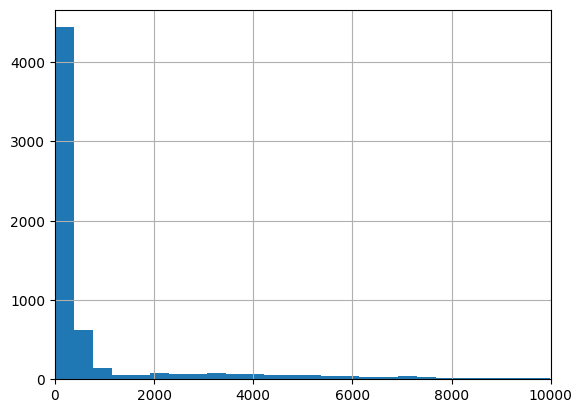

In [31]:
travel_daily2[ travel_daily2['visitor_flows'] > 10 ].pop_flows.hist(bins = 150)
plt.xlim(0, 10000) 


In [32]:
print( travel_daily2.shape  )
travel_daily3 = travel_daily2.loc[ travel_daily2['pop_flows'] > 50].reset_index()
print( travel_daily3.shape  )

(135371, 8)
(18473, 9)


In [33]:
fig = go.Figure()
fig.add_trace( go.Scattergeo(
    #locationmode = 'ISO-3',
    lon = HG_Geodata['long'],
    lat = HG_Geodata['lat'],
   # geojson = HG_Geodata['geometry'],
    hoverinfo = 'text',
    text = HG_Geodata['POPULATION'],
    mode = 'markers',
    marker = dict(
        size = 2, color = 'rgb(255, 0, 0)',
        line = dict(
            width = 3,
            color = 'rgba(68, 68, 68, 0)'
        )
    )))
	

flight_paths = []
for i in range( len( travel_daily3 ) ):
    fig.add_trace(
        go.Scattergeo(
            lon = [ travel_daily3['lng_o'][i], travel_daily3['lng_d'][i]],
            lat = [ travel_daily3['lat_o'][i], travel_daily3['lat_d'][i]],
            mode = 'lines',
            line = dict(width = 0.5,color = 'red'),
            opacity = 0.5
            #1 - float(travel_daily_HG['pop_flows'][i] ) / float(travel_daily_HG['pop_flows'].max()),
        )
    )

fig.update_layout(
    title_text = 'Texas travel',
    showlegend = False,
    geo = dict(
        scope = 'north america',
        projection_type = 'azimuthal equal area',
        showland = True,
        landcolor = 'rgb(243, 243, 243)',
        countrycolor = 'rgb(204, 204, 204)',
    ),
)

fig.show()



# Merge census block data with census tract data


In [3]:
Pth_hg_blk      = r"/Users/yuhan/Desktop/Gradient_Boost_code/inputs/gis_data/census/CenBlk_Houston_Galves.shp"
#Geodata = gpd.read_file(fp)
read_start      = time.process_time()
HG_blkdata      = read_dataframe( Pth_hg_blk )
read_end        = time.process_time()
HG_blkdata      = HG_blkdata.to_crs({'init':'epsg:4326'})
HG_blkdata.columns


/Users/yuhan/opt/anaconda3/envs/hazard_env/lib/python3.11/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


Index(['StateFIPS', 'CountyFIPS', 'TractCode', 'BlockGroup', 'CensusBloc',
       'State', 'County', 'MTFCC', 'CenBlk', 'census_blo', 'Islander',
       'Native', 'aisan', 'black', 'other', 'white', 'hispanic_A',
       'hispanic_b', 'non_hispan', 'hispanic_t', 'hispanic_w', 'hispanic_N',
       'OwnerTotVa', 'housing_un', 'Occupied', 'OwnerTot_1', '20k_35k',
       '10k_20k', 'Less10k', 'Bachelor', 'CensusBl_1', 'CensusBlk',
       'geometry'],
      dtype='object')

In [4]:
cols = ['StateFIPS', 'CountyFIPS', 'TractCode']
HG_blkdata['CTract'] = HG_blkdata[cols].apply(lambda row: ''.join(row.values.astype(str)), axis=1)

print( len( HG_blkdata['CTract'].unique() ) )

1066


In [5]:
Pth_hg          = r"/Users/yuhan/Desktop/Gradient_Boost_code/inputs/gis_data/census/Houston-galveston.shp"
#Geodata = gpd.read_file(fp)
read_start      = time.process_time()
HG_geodata      = read_dataframe( Pth_hg )
read_end        = time.process_time()
HG_geodata      = HG_geodata.to_crs({'init':'epsg:4326'})
HG_geodata.columns

/Users/yuhan/opt/anaconda3/envs/hazard_env/lib/python3.11/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


Index(['NRI_ID', 'STATE', 'STATEABBRV', 'STATEFIPS', 'COUNTY', 'COUNTYTYPE',
       'COUNTYFIPS', 'STCOFIPS', 'TRACT', 'TRACTFIPS',
       ...
       'WNTW_ALRP', 'WNTW_ALRA', 'WNTW_ALR_N', 'WNTW_RISKV', 'WNTW_RISKS',
       'WNTW_RISKR', 'NRI_VER', 'Shape_Leng', 'Shape_Area', 'geometry'],
      dtype='object', length=469)

In [6]:
print( HG_geodata.columns )
print( HG_geodata.COUNTY.unique() )


Index(['NRI_ID', 'STATE', 'STATEABBRV', 'STATEFIPS', 'COUNTY', 'COUNTYTYPE',
       'COUNTYFIPS', 'STCOFIPS', 'TRACT', 'TRACTFIPS',
       ...
       'WNTW_ALRP', 'WNTW_ALRA', 'WNTW_ALR_N', 'WNTW_RISKV', 'WNTW_RISKS',
       'WNTW_RISKR', 'NRI_VER', 'Shape_Leng', 'Shape_Area', 'geometry'],
      dtype='object', length=469)
['Brazoria' 'Chambers' 'Fort Bend' 'Galveston' 'Harris' 'Liberty'
 'Montgomery' 'Waller']


In [38]:
print( HG_blkdata.head() )
print( HG_blkdata.shape )

  StateFIPS CountyFIPS TractCode BlockGroup    CensusBloc State  \
0        48        039    662100          3  480396621003    TX   
1        48        039    662200          3  480396622003    TX   
2        48        039    662300          1  480396623001    TX   
3        48        039    662300          3  480396623003    TX   
4        48        039    662300          4  480396623004    TX   

            County  MTFCC        CenBlk    census_blo  ...  Occupied  \
0  Brazoria County  G5030  4.803966e+11  4.803966e+11  ...       824   
1  Brazoria County  G5030  4.803966e+11  4.803966e+11  ...       291   
2  Brazoria County  G5030  4.803966e+11  4.803966e+11  ...       337   
3  Brazoria County  G5030  4.803966e+11  4.803966e+11  ...       359   
4  Brazoria County  G5030  4.803966e+11  4.803966e+11  ...       588   

   OwnerTot_1  20k_35k  10k_20k  Less10k  Bachelor    CensusBl_1  \
0         578       63       99       18       418  4.803966e+11   
1         151       13      

In [39]:
len( HG_geodata.TRACTFIPS.unique() )

1594

In [40]:
HG_blkdata2 = HG_blkdata[ ['StateFIPS', 'CountyFIPS', 'State', 'County', 
                          'CenBlk', 'Islander', 'Native', 'aisan', 'black', 
                          'other', 'white', 'hispanic_A', 'hispanic_b', 
                          'non_hispan', 'hispanic_t', 'hispanic_w', 'hispanic_N',
                          'OwnerTotVa', 'housing_un', 'Occupied', 'OwnerTot_1', '20k_35k',
                            '10k_20k', 'Less10k', 'Bachelor', 'CensusBlk', 'CTract'] ]

HG_blkdata2["SumPop"] = HG_blkdata2["Islander"] + HG_blkdata2["Native"]  + HG_blkdata2["aisan"]  + HG_blkdata2["black"] + HG_blkdata2["other"] + HG_blkdata2["white"]
HG_blkdata2["LowInc"] = HG_blkdata2["20k_35k"]  + HG_blkdata2["10k_20k"] + HG_blkdata2["Less10k"] 


HG_blkdata3           = HG_blkdata2.groupby( [ 'CTract'], as_index=False ).agg({  
    "Islander" : ['sum'], "Native": ['sum'], "aisan": ['sum'], "black" : ['sum'], 
    "other" : ['sum'], "white" : ['sum'], "non_hispan" : ['sum'], 
    "OwnerTotVa": ['mean'] , "housing_un": ['sum'], "Occupied": ['sum'], 
    "OwnerTot_1": ['sum'], "LowInc": ['sum'], "Bachelor": ['sum'], "SumPop": ['sum'] 
    })
HG_blkdata3.columns = HG_blkdata3.columns.droplevel(1)


/var/folders/t6/8gnslc_j433220_1kgd9hv_c0000gn/T/ipykernel_50304/3244377.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/t6/8gnslc_j433220_1kgd9hv_c0000gn/T/ipykernel_50304/3244377.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [41]:
print(  HG_blkdata3.columns )
print(  HG_blkdata3.shape )

Index(['CTract', 'Islander', 'Native', 'aisan', 'black', 'other', 'white',
       'non_hispan', 'OwnerTotVa', 'housing_un', 'Occupied', 'OwnerTot_1',
       'LowInc', 'Bachelor', 'SumPop'],
      dtype='object')
(1066, 15)


In [42]:

result = pd.merge(HG_geodata, HG_blkdata3, left_on="TRACTFIPS", right_on="CTract", how = "left")
result.shape
result.to_file(r"/Users/yuhan/Desktop/Gradient_Boost_code/inputs/travel/HG_cen_tract.shp")


In [43]:
travel_daily3.head()

index      geoid_o      geoid_d     lng_o      lat_o      lng_d      lat_d  \
0      0  48039660100  48039660100 -95.23168  29.552359 -95.231680  29.552359   
1      1  48039660100  48039660200 -95.23168  29.552359 -95.237135  29.512338   
2      2  48039660100  48039660300 -95.23168  29.552359 -95.261106  29.544076   
3      3  48039660100  48039660400 -95.23168  29.552359 -95.271428  29.575815   
4      4  48039660100  48039660500 -95.23168  29.552359 -95.318047  29.577835   

   visitor_flows  pop_flows  
0            353     4105.0  
1             15      174.0  
2             33      383.0  
3             40      465.0  
4              6       69.0

In [44]:
travel_daily3.columns

Index(['index', 'geoid_o', 'geoid_d', 'lng_o', 'lat_o', 'lng_d', 'lat_d',
       'visitor_flows', 'pop_flows'],
      dtype='object')

# Population flow in census tract

In [45]:

flows_unit = []
for i, row in enumerate( travel_daily2.itertuples() ):
    if row.geoid_o == "{}":
        continue
    else:
        origin      = row.geoid_o
        destination = row.geoid_d
        v           = row.visitor_flows
        flows_unit.append([origin, destination, v])
print( len(flows_unit) )

135371


In [46]:
travel_daily2.to_csv( r"/Users/yuhan/Desktop/Gradient_Boost_code/inputs/travel/daily_travel_Houston_Galveston.csv", index=False ) 

# Join census to parcel 

In [47]:
Pth_tf6             = r"/Users/yuhan/Desktop/Gradient_Boost_code/inputs/gis_data/gis_parcel_Galveston/Parcels_inputs_TF6_3.shp"
#Geodata = gpd.read_file(fp)
read_start          = time.process_time()
Parcels_geodata     = read_dataframe( Pth_tf6 )
read_end            = time.process_time()
Parcels_geodata     = Parcels_geodata.to_crs({'init':'epsg:4326'})
Parcels_geodata.columns

/Users/yuhan/opt/anaconda3/envs/hazard_env/lib/python3.11/site-packages/pyproj/crs/crs.py:141: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6



Index(['index', 'FID_1', 'OBJECTID', 'GEOID', 'ID', 'NAME', 'ADDRESS2',
       'ADDRESS3', 'CITY', 'ST',
       ...
       'EducationL', 'unitPrice', 'LandPrice', 'CensusBloc', 'dem_mhw',
       'slope_mhw', 'release', 'capture_da', 'area_2', 'geometry'],
      dtype='object', length=123)

In [48]:
Pth_HG_centract     = r"/Users/yuhan/Desktop/Gradient_Boost_code/inputs/travel/HG_cen_tract.shp"
#Geodata = gpd.read_file(fp)
read_start       = time.process_time()
HG_cen_tract     = read_dataframe( Pth_HG_centract )
read_end         = time.process_time()
HG_cen_tract     = HG_cen_tract.to_crs({'init':'epsg:4326'})
HG_cen_tract.columns


/Users/yuhan/opt/anaconda3/envs/hazard_env/lib/python3.11/site-packages/pyproj/crs/crs.py:141: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6



Index(['NRI_ID', 'STATE', 'STATEABBRV', 'STATEFIPS', 'COUNTY', 'COUNTYTYPE',
       'COUNTYFIPS', 'STCOFIPS', 'TRACT', 'TRACTFIPS',
       ...
       'white', 'non_hispan', 'OwnerTotVa', 'housing_un', 'Occupied',
       'OwnerTot_1', 'LowInc', 'Bachelor', 'SumPop', 'geometry'],
      dtype='object', length=484)

In [49]:
print( HG_cen_tract.bounds )

           minx       miny       maxx       maxy
0    -95.255201  29.541256 -95.214567  29.561436
1    -95.260117  29.472586 -95.219105  29.547399
2    -95.286077  29.546176 -95.255201  29.563776
3    -95.277060  29.534688 -95.244664  29.552529
4    -95.270286  29.521373 -95.231929  29.548240
...         ...        ...        ...        ...
1589 -96.131753  29.912205 -95.958027  30.115566
1590 -96.192222  30.043735 -95.941303  30.236975
1591 -95.944659  30.081733 -95.803344  30.166500
1592 -95.969708  30.140677 -95.803821  30.245656
1593 -95.998189  30.086919 -95.965211  30.104597

[1594 rows x 4 columns]


In [50]:
pth_x           = r"/Users/yuhan/Desktop/Gradient_Boost_code/inputs/travel/daily_travel_Houston_Galveston.csv"
travel_daily    = pd.read_csv( pth_x )
print(travel_daily.head() )
print(travel_daily.columns)

       geoid_o      geoid_d     lng_o      lat_o      lng_d      lat_d  \
0  48039660100  48039660100 -95.23168  29.552359 -95.231680  29.552359   
1  48039660100  48039660200 -95.23168  29.552359 -95.237135  29.512338   
2  48039660100  48039660300 -95.23168  29.552359 -95.261106  29.544076   
3  48039660100  48039660400 -95.23168  29.552359 -95.271428  29.575815   
4  48039660100  48039660500 -95.23168  29.552359 -95.318047  29.577835   

   visitor_flows  pop_flows  
0            353     4105.0  
1             15      174.0  
2             33      383.0  
3             40      465.0  
4              6       69.0  
Index(['geoid_o', 'geoid_d', 'lng_o', 'lat_o', 'lng_d', 'lat_d',
       'visitor_flows', 'pop_flows'],
      dtype='object')


In [51]:
Parcels_geodata['CensusBlk'].head()

0    4.816772e+11
1    4.816772e+11
2    4.816772e+11
3    4.816772e+11
4    4.816772e+11
Name: CensusBlk, dtype: float64

In [52]:
Parcels_geodata['CensusBlk'] = Parcels_geodata['CensusBlk'].astype(str)
Parcels_geodata['CensusTck'] = Parcels_geodata['CensusBlk'].str.slice(0, 11)

In [53]:
print( Parcels_geodata['CensusTck'].loc[2], type( Parcels_geodata.CensusTck.loc[2]) )
print( HG_cen_tract.TRACTFIPS.loc[2], type( HG_cen_tract.TRACTFIPS.loc[2]) )
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

48167723600 <class 'str'>
48039660301 <class 'str'>


In [224]:
print(Parcels_geodata.columns.tolist())

['index', 'FID_1', 'OBJECTID', 'GEOID', 'ID', 'NAME', 'ADDRESS2', 'ADDRESS3', 'CITY', 'ST', 'ZIP', 'SITUS_NO', 'SITUS', 'LEGAL', 'ENTITIES', 'ACRES', 'LANDUSE', 'PAGE', 'NBHD', 'INTEREST', 'EXEMPT', 'FLAGS', 'SECURE', 'VAL19LAND', 'VAL19IMP', 'VAL19TOT', 'Bldg_Area', 'Bldg_Value', 'N_Storie', 'Prop_Use', 'Occupancy', 'Foundation', 'N_Units', 'Parcel_A', 'FFE_m', 'D_max', 'H_max', 'H_ft', 'Year_Built', 'CensusBlk', 'PopTot', 'TotHisp', 'GroupQuart', 'TotalUnit', 'Mobile', 'vacant', 'MedHHInc', 'TotAge65', 'Unempolyme', 'BelowHigh', 'BelPoverty', 'Minority', 'SinglFamiy', 'PopWhite', 'POPULATION', 'POP_SQMI', 'ZipCode', 'CostsPer', 'BUILDVALUE', 'AGRIVALUE', 'RISK_SCORE', 'EAL_SCORE', 'EAL_VALT', 'EAL_VALB', 'SOVI_VALUE', 'RESL_VALUE', 'CFLD_EVNTS', 'CFLD_EXPB', 'CFLD_EXPT', 'CFLD_EALB', 'DEM', 'DEMmhw', 'Cate1', 'Cate2', 'Cate3', 'Cate4', 'Cate5', 'lu01', 'lu06', 'lu11', 'lu15', 'lu20', 'BeachDist', 'HealthDist', 'ParkDist', 'SchoolDist', 'ShopDist', 'CoastDist', 'WetlatDist', 'Long', '

<Axes: >

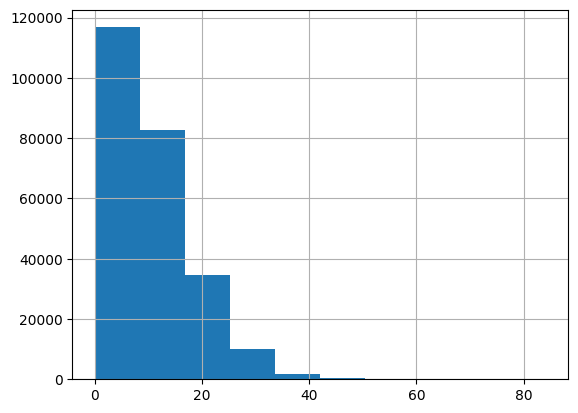

In [54]:
Parcels_geodata.slope.hist()

In [55]:
Parcels_geodata2 = Parcels_geodata[ [
'index', 'FID_1', 'GEOID', 'ID', 'NAME',  
'CITY', 'ST', 'ZIP', 'SITUS_NO', 'ENTITIES', 'ACRES', 'LANDUSE', 
'PAGE', 'NBHD', 'INTEREST', 'EXEMPT', 'FLAGS', 'VAL19LAND', 'VAL19IMP', 
'VAL19TOT', 'Bldg_Area', 'Bldg_Value', 'N_Storie', 'Prop_Use', 
'Occupancy', 'Foundation', 'N_Units', 'Parcel_A', 'FFE_m', 'D_max', 
'H_max', 'H_ft', 'Year_Built', 'CensusBlk', 'PopTot', 'TotHisp', 
'GroupQuart', 'TotalUnit', 'Mobile', 'vacant', 'MedHHInc', 
'TotAge65', 'Unempolyme', 'BelowHigh', 'BelPoverty', 
'Minority', 'SinglFamiy', 'PopWhite', 'POPULATION', 
'POP_SQMI', 'ZipCode', 'CostsPer', 'BUILDVALUE', 
'AGRIVALUE', 'RISK_SCORE', 'EAL_VALT', 
'EAL_VALB', 'SOVI_VALUE', 'RESL_VALUE', 'CFLD_EVNTS', 
'CFLD_EXPB', 'CFLD_EXPT', 'DEM', 'DEMmhw', 
'Cate1', 'Cate2', 'Cate3', 'Cate4', 'Cate5', 
'lu01', 'lu06', 'lu11', 'lu15', 'lu20', 
'BeachDist', 'HealthDist', 'ParkDist', 'SchoolDist', 'ShopDist', 'CoastDist', 'WetlatDist', 
'Long', 'Lati', 'floodzones', 'buildDEM', 'PArea', 'NEIGHBORS', 'watercode', 'parkigcode', 
'parkigcode', 'rddist', 'rddens', 'slope', 
'area', 'SurvJV', 'Race', 'income', 'EducationL', 'unitPrice', 'LandPrice', 
'CensusBloc', 'dem_mhw', 'slope_mhw', 'release', 'area_2', 
'geometry', 'CensusTck'
] ]


In [22]:
result2 = pd.merge(Parcels_geodata, HG_cen_tract, left_on="CensusTck", right_on="TRACTFIPS", how = "left")
result2.head()

# Read Transportation Network

In [ ]:

ox.config(use_cache=True, log_console=True)


        minx       miny       maxx       maxy
0 -95.233081  28.996344 -94.366279  29.598264


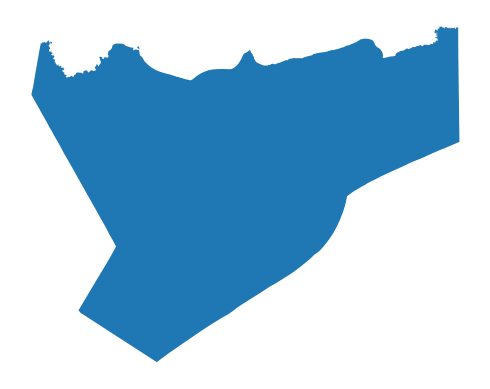

In [57]:
city = ox.geocode_to_gdf('Galveston, Texas')
ax = ox.project_gdf(city).plot()
_ = ax.axis('off')

print( city.bounds )


        minx       miny       maxx       maxy
0 -95.233081  28.996344 -94.366279  29.598264
1 -95.960846  29.497339 -94.908492  30.170734


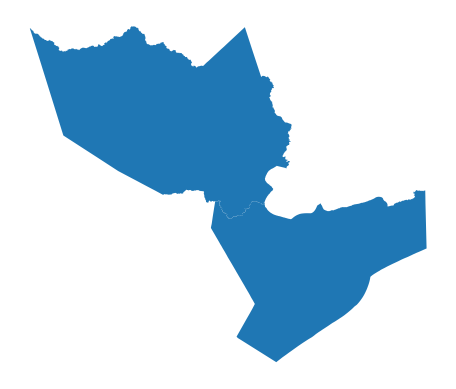

In [58]:
#places = ox.geocode_to_gdf(['Galveston, Texas', 'Harris, Texas'])
places = ox.geocode_to_gdf([ 'Galveston, Texas' ])
places = ox.project_gdf(places)
places = places.to_crs(4326) 

ax = places.plot()
_ = ax.axis('off')
print( places.bounds )

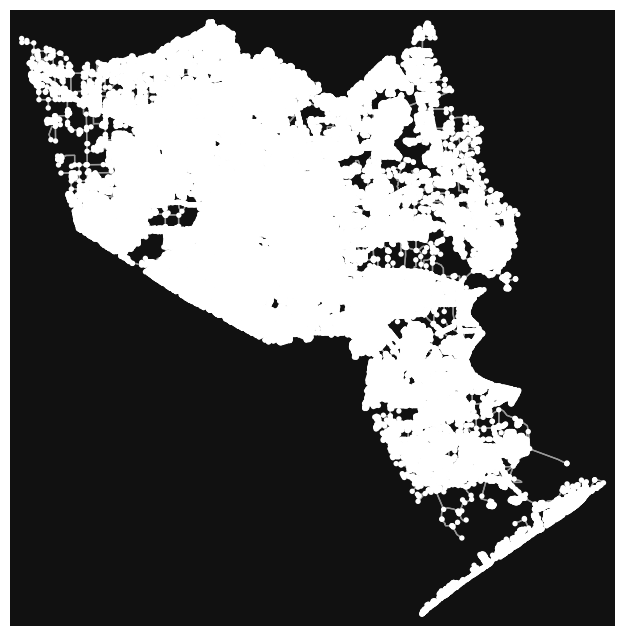

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [60]:
G_galveston = ox.graph_from_place([ 'Galveston, Texas', 'Harris, Texas'], network_type='drive')
ox.plot_graph( G_galveston )

In [61]:
# convert graph to geodataframes
gdf_edges = ox.graph_to_gdfs( G_galveston, nodes=False )

# list of lats and lngs
lngs = gdf_edges.head().centroid.map(lambda x: x.coords[0][0])
lats = gdf_edges.head().centroid.map(lambda x: x.coords[0][1])

# the lat, lng at the spatial center of the graph
lng, lat = gdf_edges.unary_union.centroid.coords[0]
center_point = lat, lng


/var/folders/t6/8gnslc_j433220_1kgd9hv_c0000gn/T/ipykernel_50304/2027373458.py:5: UserWarning:

Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.


/var/folders/t6/8gnslc_j433220_1kgd9hv_c0000gn/T/ipykernel_50304/2027373458.py:6: UserWarning:

Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.




In [62]:
lng, lat

(-95.36601254793425, 29.78255571209643)

In [63]:
# find the nearest node to some point
center_node = ox.distance.nearest_nodes( G_galveston, lng, lat )
print( center_node )

152165169


In [64]:
travel_daily2[ ['lng_o', 'lat_o', 'lng_d', 'lat_d'] ].head()

lng_o      lat_o      lng_d      lat_d
0 -95.23168  29.552359 -95.231680  29.552359
1 -95.23168  29.552359 -95.237135  29.512338
2 -95.23168  29.552359 -95.261106  29.544076
3 -95.23168  29.552359 -95.271428  29.575815
4 -95.23168  29.552359 -95.318047  29.577835

In [65]:
origin = (29.5715037776025, -95.6214738696114)
destination = (29.1833221718174, -95.021263563624)
origin_node = ox.distance.nearest_nodes(G_galveston, origin[1], origin[0])
destination_node = ox.distance.nearest_nodes(G_galveston, destination[1], destination[0] )
route = nx.shortest_path(G_galveston, origin_node, destination_node)


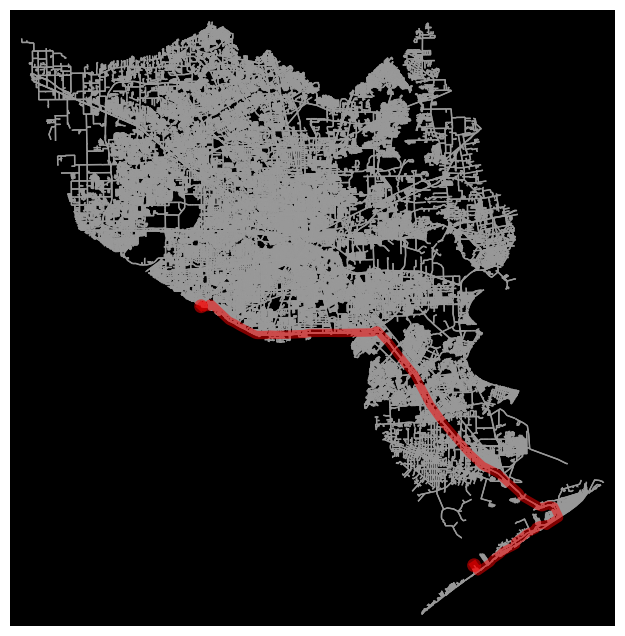

In [66]:
fig, ax = ox.plot_graph_route(G_galveston, route, route_linewidth=6, node_size=0, bgcolor='k')

In [67]:
# impute speed on all edges missing data
G_galveston = ox.add_edge_speeds( G_galveston )
# calculate travel time (seconds) for all edges
G_galveston = ox.add_edge_travel_times( G_galveston )

In [68]:
# see mean speed/time values by road type
edges = ox.graph_to_gdfs(G_galveston, nodes=False)
edges['highway'] = edges['highway'].astype(str)
edges.groupby('highway')[['length', 'speed_kph', 'travel_time']].mean().round(1)

length  speed_kph  travel_time
highway                                                            
['motorway_link', 'motorway']        1484.3       96.6         54.2
['motorway_link', 'secondary']        576.6       87.1         23.8
['motorway_link', 'secondary_link']    59.8       87.1          2.5
['motorway_link', 'tertiary']         835.0       87.1         34.5
['primary', 'motorway']               777.5       96.6         29.0
['primary', 'secondary']              347.8       66.6         18.0
['primary', 'secondary_link']         129.4       63.8          7.3
['primary', 'tertiary']               402.7       48.3         30.0
['primary_link', 'secondary_link']    389.4       63.0         22.2
['primary_link', 'tertiary']          208.8       62.2         12.2
['primary_link', 'unclassified']      319.3       63.0         18.2
['residential', 'secondary']          634.1       44.4         51.4
['residential', 'tertiary']           394.4       44.5         32.0
['residential', 'unclassified']       458.5       44.2         37.4
['secondary', 'secondary_link']       308.3       64.5         16.6
['secondary', 'tertiary']             343.2       60.3         20.3
['tertiary', 'secondary_link']        799.9       50.0         57.6
['tertiary', 'tertiary_link']         303.4       50.0         21.9
['trunk', 'primary']                 1056.4       96.6         39.4
['trunk_link', 'tertiary']            320.4       56.3         20.5
['unclassified', 'motorway_link']    1075.2       32.3        119.8
['unclassified', 'residential']       477.0       32.2         53.3
['unclassified', 'tertiary']          909.3       32.3        101.3
busway                                143.4       64.6          8.0
disused                               190.7       64.6         10.6
living_street                          85.5       64.6          4.8
motorway                              982.4      100.4         35.1
motorway_link                         394.5       87.1         16.3
primary                               169.6       63.8          9.5
primary_link                           48.0       63.0          2.7
residential                           143.9       44.4         11.7
secondary                             148.4       61.3          8.7
secondary_link                         35.0       66.0          1.9
tertiary                              152.5       50.0         11.0
tertiary_link                          20.4       64.6          1.1
trunk                                 321.3       78.7         14.4
trunk_link                            150.2       64.2          8.4
unclassified                          194.6       32.3         21.7

In [69]:
# same thing again, but this time pass in a few default speed values (km/hour)
# to fill in edges with missing `maxspeed` from OSM 
#units meters and seconds
hwy_speeds = { 'residential' : 35,
               'secondary'   : 50,
               'tertiary'    : 60 }
G_galveston = ox.add_edge_speeds( G_galveston , hwy_speeds)
G_galveston = ox.add_edge_travel_times(G_galveston)

In [70]:
# calculate two routes by minimizing travel distance vs travel time
orig = list( G_galveston )[100]
dest = list( G_galveston )[-200]
print( orig, dest )

224386803 11099176128


In [71]:
route1 = nx.shortest_path(G_galveston, orig, dest, weight='length')
route2 = nx.shortest_path(G_galveston, orig, dest, weight='travel_time')

In [72]:
# compare the two routes
route1_length = int(sum(ox.utils_graph.get_route_edge_attributes(G_galveston, route1, 'length')))
route2_length = int(sum(ox.utils_graph.get_route_edge_attributes(G_galveston, route2, 'length')))
route1_time = int(sum(ox.utils_graph.get_route_edge_attributes(G_galveston, route1, 'travel_time')))
route2_time = int(sum(ox.utils_graph.get_route_edge_attributes(G_galveston, route2, 'travel_time')))
print('Route 1 is', route1_length, 'meters and takes', route1_time, 'seconds.')
print('Route 2 is', route2_length, 'meters and takes', route2_time, 'seconds.')

Route 1 is 104090 meters and takes 5779 seconds.
Route 2 is 118198 meters and takes 4463 seconds.


/var/folders/t6/8gnslc_j433220_1kgd9hv_c0000gn/T/ipykernel_50304/1425529208.py:2: UserWarning:

The `get_route_edge_attributes` function has been deprecated and will be removed in a future release. Use the `route_to_gdf` function instead.

/var/folders/t6/8gnslc_j433220_1kgd9hv_c0000gn/T/ipykernel_50304/1425529208.py:3: UserWarning:

The `get_route_edge_attributes` function has been deprecated and will be removed in a future release. Use the `route_to_gdf` function instead.

/var/folders/t6/8gnslc_j433220_1kgd9hv_c0000gn/T/ipykernel_50304/1425529208.py:4: UserWarning:

The `get_route_edge_attributes` function has been deprecated and will be removed in a future release. Use the `route_to_gdf` function instead.

/var/folders/t6/8gnslc_j433220_1kgd9hv_c0000gn/T/ipykernel_50304/1425529208.py:5: UserWarning:

The `get_route_edge_attributes` function has been deprecated and will be removed in a future release. Use the `route_to_gdf` function instead.



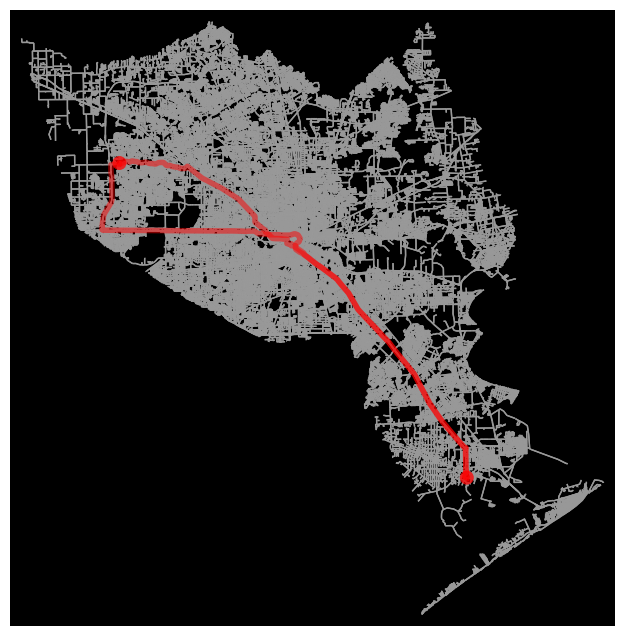

In [73]:
# pick route colors
c1  = 'r' #length
c2  = 'b' #travel_time
rc1 = [c1] * (len(route1) - 1)
rc2 = [c2] * (len(route2) - 1)
rc  = rc1 + rc2
nc  = [c1, c1, c2, c2]

# plot the routes
fig, ax = ox.plot_graph_routes( G_galveston, [route1, route2], 
                                route_color = rc, route_linewidth = 6,
                                node_size = 0, bgcolor = 'k')


In [74]:
travel_daily2.shape


(135371, 8)

In [75]:
nrows = travel_daily2.shape[0]
pth_x           = r"/Users/yuhan/Desktop/Gradient_Boost_code/inputs/travel/daily_travel_Houston_Galveston.csv"
travel_daily    = pd.read_csv( pth_x )
number_of_rows = len(travel_daily.index) + 1
print(pth_x[:-4])
print( travel_daily.columns )


/Users/yuhan/Desktop/Gradient_Boost_code/inputs/travel/daily_travel_Houston_Galveston
Index(['geoid_o', 'geoid_d', 'lng_o', 'lat_o', 'lng_d', 'lat_d',
       'visitor_flows', 'pop_flows'],
      dtype='object')


In [77]:
file_increment = 1
skip_rows = 1
## first file random numbers
number_of_rows_perfile = 20000
number_of_rows = len(travel_daily.index) + 1

while True:
    if number_of_rows_perfile <= 0:
        break
    ## Read CSV file with number of rows and skip respective number of lines
    dfi = pd.read_csv( pth_x, header=None, nrows = number_of_rows_perfile, skiprows = skip_rows)
    ## Target file name
    #split_target_file = f"{pth_x[:-4]}_{file_increment}.csv"
    split_target_file = f"/Users/yuhan/Desktop/Gradient_Boost_code/inputs/travel/splited/daily_travel_Houston_Galveston_{file_increment}.csv"
    dfi.columns = travel_daily.columns
    ## write to csv 
    dfi.to_csv(split_target_file, index = False, header = True, 
              chunksize = number_of_rows_perfile)
    file_increment += 1
    skip_rows += number_of_rows_perfile
    ## Last file handler
    if skip_rows >= number_of_rows:
        number_of_rows_perfile = number_of_rows - skip_rows

In [78]:
warnings.filterwarnings("ignore")
pth_root = r"/Users/yuhan/Desktop/Gradient_Boost_code/inputs/travel/splited"
path_list = [ 
              "daily_travel_Houston_Galveston_4.csv",
              "daily_travel_Houston_Galveston_5.csv",
              "daily_travel_Houston_Galveston_6.csv",
              "daily_travel_Houston_Galveston_7.csv" ]
for pathi in path_list:
    arget_filei = f"{pth_root}/{pathi}"
    print( arget_filei )
    travel_dailyi = pd.read_csv( arget_filei )
    path_count = 0
    daily_travel_i = []
    unaccess_count = 0
    print( travel_dailyi.head() )
    for index, row in travel_dailyi.iterrows():
        origin                  = ( row['lng_o'], row['lat_o'] )
        destination             = ( row['lng_d'], row['lat_d'] )
        origin_node             = ox.distance.nearest_nodes( G_galveston, origin[0], origin[1] )
        destination_node        = ox.distance.nearest_nodes( G_galveston, destination[0], destination[1] )
        try:
            routei                  = nx.shortest_path(G_galveston, origin_node, destination_node)
            row['route_leng']       = int(sum(ox.utils_graph.get_route_edge_attributes(G_galveston, routei, 'length')))
            row['route_time']       = int(sum(ox.utils_graph.get_route_edge_attributes(G_galveston, routei, 'travel_time')))
        except Exception as NetworkXNoPath:
            unaccess_count = unaccess_count + 1
            if unaccess_count % 50 == 0:
                print("The number of unaccesible route", unaccess_count)
        path_count = path_count + 1
        daily_travel_i.append( row )
        if path_count % 500 == 0:
            print("Total path # is ", path_count)
    daily_travel_i = pd.DataFrame( daily_travel_i )
    daily_travel_i.to_csv( arget_filei, index=False ) 

/Users/yuhan/Desktop/Gradient_Boost_code/inputs/travel/splited/daily_travel_Houston_Galveston_1.csv
       geoid_o      geoid_d     lng_o      lat_o      lng_d      lat_d  \
0  48039660100  48039660100 -95.23168  29.552359 -95.231680  29.552359   
1  48039660100  48039660200 -95.23168  29.552359 -95.237135  29.512338   
2  48039660100  48039660300 -95.23168  29.552359 -95.261106  29.544076   
3  48039660100  48039660400 -95.23168  29.552359 -95.271428  29.575815   
4  48039660100  48039660500 -95.23168  29.552359 -95.318047  29.577835   

   visitor_flows  pop_flows  
0            353     4105.0  
1             15      174.0  
2             33      383.0  
3             40      465.0  
4              6       69.0  
Total path # is  500
Total path # is  1000
Total path # is  1500
The number of unaccesible route 50
Total path # is  2000
Total path # is  2500
Total path # is  3000
The number of unaccesible route 100
Total path # is  3500
Total path # is  4000
Total path # is  4500
The num

In [248]:
row

geoid_o          4.801576e+10
geoid_d          4.815768e+10
lng_o           -9.610299e+01
lat_o            2.966415e+01
lng_d           -9.577194e+01
lat_d            2.954950e+01
visitor_flows    1.000000e+00
pop_flows        1.300000e+01
Name: 19, dtype: float64

In [90]:
pth_root = r"/Users/yuhan/Desktop/Gradient_Boost_code/inputs/travel/splited/" 
csv_files2 = glob.glob(os.path.join(pth_root, "*.csv")) 
#print( csv_files2 )
df_daily2 = []
# loop over the list of csv files 
for f in csv_files2: 
    # read the csv file 
    travel_daily_dfx  = pd.read_csv(f) 
    #print( travel_daily_dfx.columns )
    df_daily2.append( travel_daily_dfx )
travel_dailyx = pd.concat( df_daily2 )
print( "travel_daily shape ", travel_dailyx.shape ) 
print( "travel_daily shape ", travel_dailyx.head() ) 


travel_daily shape  (135371, 10)
travel_daily shape          geoid_o       geoid_d     lng_o      lat_o      lng_d      lat_d  \
0  4.803966e+10  4.803966e+10 -95.23168  29.552359 -95.231680  29.552359   
1  4.803966e+10  4.803966e+10 -95.23168  29.552359 -95.237135  29.512338   
2  4.803966e+10  4.803966e+10 -95.23168  29.552359 -95.261106  29.544076   
3  4.803966e+10  4.803966e+10 -95.23168  29.552359 -95.271428  29.575815   
4  4.803966e+10  4.803966e+10 -95.23168  29.552359 -95.318047  29.577835   

   visitor_flows  pop_flows  route_leng  route_time  
0          353.0     4105.0         0.0         0.0  
1           15.0      174.0     16461.0      1338.0  
2           33.0      383.0      4547.0       433.0  
3           40.0      465.0      6539.0       583.0  
4            6.0       69.0     15568.0       979.0  


In [91]:

travel_dailyx.to_csv( r"/Users/yuhan/Desktop/Gradient_Boost_code/inputs/travel/daily_travel_Hou_Galv_updated.csv", index=False ) 

In [79]:
path = os.getcwd() 
print(path)

/Users/yuhan/Desktop/Gradient_Boost_code
